In [1]:
# 需要的包
from PyQt5 import QtCore, QtGui, QtWidgets
from PyQt5.QtGui import *
from PyQt5.QtWidgets import *
from PyQt5.QtCore import *
from PyQt5.QtWidgets import QFileDialog
import sys
import qtawesome
import numpy as np
import tensorflow as tf
import os
import cv2 as cv
import pickle
from pywt import dwt2, idwt2
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from skimage.feature import local_binary_pattern
from skimage import data, io,data_dir,filters, feature

F:\anaconda\envs\GP\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
# 程序所需的链接和模型等
global image
image = []
global selectStr
selectStr = "FACE"
global selectCNNorSVM
selectCNNorSVM = "CNN"
global Predict_Image_Path
Predict_Image_Path = 'c:\\'

In [3]:
# 读取预测的图像数据
def readImage(imagePath):
        #   添加文件图片数据 
        src = cv.imread(imagePath)
        image = cv.cvtColor(src, cv.COLOR_BGR2GRAY)   
        image = cv.resize(
                          image, 
                          (256, 256),
                          interpolation=cv.INTER_AREA
                           )  
        image = image.flatten()
        return image
    

In [4]:
def glcm(arr, d_x, d_y, gray_level=16):
    '''计算并返回归一化后的灰度共生矩阵'''
    max_gray = arr.max()
    height, width = arr.shape
    arr = arr.astype(np.float64)  # 将uint8类型转换为float64，以免数据失真
    arr = arr * (gray_level - 1) // max_gray  # 若灰度级数大于gray_level，则将图像的灰度级缩小至gray_level，减小灰度共生矩阵的大小。量化后灰度值范围：0 ~ gray_level - 1
    ret = np.zeros([gray_level, gray_level])
    for j in range(height -  abs(d_y)):
        for i in range(width - abs(d_x)):  # range(width - d_x)  #注释为源代码，经评论指出错误后修改
            rows = arr[j][i].astype(int)
            cols = arr[j + d_y][i + d_x].astype(int)
            ret[rows][cols] += 1
    if d_x >= d_y:
        ret = ret / float(height * (width - 1))  # 归一化, 水平方向或垂直方向
    else:
        ret = ret / float((height - 1) * (width - 1))  # 归一化, 45度或135度方向
    return ret

In [ ]:
# 界面设计
class MainUi(QtWidgets.QMainWindow):
    def __init__(self):
        
        super().__init__()
        self.init_ui()
 
    def init_ui(self):
        self.setFixedSize(1200,800)
        self.setWindowTitle("基于多特征的脑肿瘤图像识别")
        
        self.main_widget = QtWidgets.QWidget()  # 创建窗口主部件
        self.main_layout = QtWidgets.QGridLayout()  # 创建主部件的网格布局
        self.main_widget.setLayout(self.main_layout)  # 设置窗口主部件布局为网格布局
 
#  左侧设置
        self.left_widget = QtWidgets.QWidget()  # 创建左侧部件
        self.left_widget.setObjectName('left_widget')
        self.left_layout = QtWidgets.QGridLayout()  # 创建左侧部件的网格布局层
        self.left_widget.setLayout(self.left_layout) # 设置左侧部件布局为网格
 
        self.right_widget = QtWidgets.QWidget() # 创建右侧部件
        self.right_widget.setObjectName('right_widget')
        self.right_layout = QtWidgets.QGridLayout()
        self.right_widget.setLayout(self.right_layout) # 设置右侧部件布局为网格
 
        self.main_layout.addWidget(self.left_widget,0,0,12,2) # 左侧部件在第0行第0列，占8行3列
        self.main_layout.addWidget(self.right_widget,0,2,12,10) # 右侧部件在第0行第3列，占8行9列
        self.setCentralWidget(self.main_widget) # 设置窗口主部件
        
        self.left_close = QtWidgets.QPushButton("") # 关闭按钮
        self.left_visit = QtWidgets.QPushButton("") # 空白按钮
        self.left_mini = QtWidgets.QPushButton("")  # 最小化按钮
 
        self.left_label_1 = QtWidgets.QPushButton("本机测试")
        self.left_label_1.setObjectName('left_label')
        self.left_label_3 = QtWidgets.QPushButton("联系与帮助")
        self.left_label_3.setObjectName('left_label')
 
        self.left_button_1 = QtWidgets.QPushButton(qtawesome.icon('fa.music',color='white'),"导入图像")
        self.left_button_1.clicked.connect(self.loadFile)
        self.left_button_1.setObjectName('left_button')
        
        self.left_button_2 = QtWidgets.QComboBox()
        self.left_button_2.addItem('FACE-model')
        self.left_button_2.addItem('BACK-model')
        self.left_button_2.addItem('UP-model')
        self.left_button_2.addItem('LEFT-model')
        self.left_button_2.addItem('EYE-model')
        self.left_button_2.currentIndexChanged.connect(self.selectionchange)
        
        self.left_button_3 = QtWidgets.QComboBox()
        self.left_button_3.addItem("CNN-model")
        self.left_button_3.addItem("SVM-model")
        self.left_button_3.currentIndexChanged.connect(self.selectCNNorSVM)
        
#         self.left_button_2 = QtWidgets.QPushButton(qtawesome.icon('fa.sellsy',color='white'),"选择部位")
#         self.left_button_2.clicked.connect(self.selectSite)
        self.left_button_2.setObjectName('left_button')
        
        
        self.left_button_4 = QtWidgets.QPushButton(qtawesome.icon('fa.film',color='white'),"开始测试")
        self.left_button_4.setObjectName('left_button')
        self.left_button_4.clicked.connect(self.runTest)
        
        self.left_button_5 = QtWidgets.QPushButton(qtawesome.icon('fa.comment',color='white'),"反馈建议")
        self.left_button_5.setObjectName('left_button')
        
        self.left_button_6 = QtWidgets.QPushButton(qtawesome.icon('fa.star',color='white'),"关注我们")
        self.left_button_6.setObjectName('left_button')
        
        self.left_button_7 = QtWidgets.QPushButton(qtawesome.icon('fa.question',color='white'),"遇到问题")
        self.left_button_7.setObjectName('left_button')
        
        self.left_xxx = QtWidgets.QPushButton(" ")
        
        self.left_layout.addWidget(self.left_mini, 0, 0,1,1)
        self.left_layout.addWidget(self.left_close, 0, 2,1,1)
        self.left_layout.addWidget(self.left_visit, 0, 1, 1, 1)
        self.left_layout.addWidget(self.left_label_1,1,0,1,3)
        self.left_layout.addWidget(self.left_button_1, 2, 0,1,3)
        self.left_layout.addWidget(self.left_button_2, 3, 0,1,3)
        self.left_layout.addWidget(self.left_button_3, 4, 0,1,3)
        self.left_layout.addWidget(self.left_button_4, 5, 0,1,3)
        
        self.left_layout.addWidget(self.left_label_3, 10, 0,1,3)
        self.left_layout.addWidget(self.left_button_5, 11, 0,1,3)
        self.left_layout.addWidget(self.left_button_6, 12, 0, 1, 3)
        self.left_layout.addWidget(self.left_button_7, 13, 0, 1, 3)
        
# 右侧设置

        self.right_label_1 = QtWidgets.QLabel("显示患者的脑CT/MR图像")
        self.right_label_1.setObjectName('right_label')
        self.right_layout.addWidget(self.right_label_1, 0, 0, 1, 10)
        self.right_label_1.setGeometry(QtCore.QRect(200, 200, 512, 512))
        self.right_label_1.setFrameShape(QtWidgets.QFrame.Box)
        self.right_label_1.setFrameShadow(QtWidgets.QFrame.Raised)
        self.right_label_1.setScaledContents(True)
        self.right_label_1.setStyleSheet('''
            #right_label{background-color: gray}
        ''')
        
        self.left_close.setFixedSize(15,15) # 设置关闭按钮的大小
        self.left_visit.setFixedSize(15, 15)  # 设置按钮大小
        self.left_mini.setFixedSize(15, 15) # 设置最小化按钮大小
        
        self.left_close.setStyleSheet('''QPushButton{background:#F76677;border-radius:5px;}QPushButton:hover{background:red;}''')
        self.left_visit.setStyleSheet('''QPushButton{background:#F7D674;border-radius:5px;}QPushButton:hover{background:yellow;}''')
        self.left_mini.setStyleSheet('''QPushButton{background:#6DDF6D;border-radius:5px;}QPushButton:hover{background:green;}''')
        
        
        self.left_button_2.setStyleSheet("""
          QComboBox{font-family:Microsoft YaHei;border:1px;
          border-color#252525:border-radius:2px;background: #404040;font:12px;color:white;height: 30px;}
          QComboBox:editable{background:black;}
          QComboBox QAbstractItemView{border: 0px;outline:0px;
          selection-background-color: blue;height:100px;background: rgb(1,58,80);color:white;font-size:12px}
          QComboBox QAbstractItemView::item {height:30px;}
          QComboBox QAbstractItemView::item:selected{background-color: blue;}
          QComboBox::down-arrow{image:url(application/resources/icons/combo_arrow.png);}
          QComboBox::drop-down{border:0px;}
        """)
        self.left_button_3.setStyleSheet("""
          QComboBox{font-family:Microsoft YaHei;border:1px;
          border-color#252525:border-radius:2px;background: #404040;font:12px;color:white;height: 30px;}
          QComboBox:editable{background:black;}
          QComboBox QAbstractItemView{border: 0px;outline:0px;
          selection-background-color: blue;height:100px;background: rgb(1,58,80);color:white;font-size:12px}
          QComboBox QAbstractItemView::item {height:30px;}
          QComboBox QAbstractItemView::item:selected{background-color: blue;}
          QComboBox::down-arrow{image:url(application/resources/icons/combo_arrow.png);}
          QComboBox::drop-down{border:0px;}
        """)
        
        
        self.left_widget.setStyleSheet('''
            QPushButton{border:none;color:white;}
            QPushButton#left_label{
                border:none;
                border-bottom:1px solid white;
                font-size:18px;
                font-weight:700;
                font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;
            }
            QPushButton#left_button:hover{border-left:4px solid red;font-weight:700;}
        ''')
        
        
        self.right_widget.setStyleSheet('''
            QWidget#right_widget{
                color:#232C51;
                background:white;
                border-top:1px solid darkGray;
                border-bottom:1px solid darkGray;
                border-right:1px solid darkGray;
                border-top-right-radius:10px;
                border-bottom-right-radius:10px;
            }
            QLabel#right_lable{
                border:none;
                font-size:16px;
                font-weight:700;
                font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;
            }
        ''')
        
# 整体设置
        self.setWindowOpacity(0.95) # 设置窗口透明度
        self.setAttribute(QtCore.Qt.WA_TranslucentBackground) # 设置窗口背景透明
        self.main_layout.setSpacing(0)
        
#  加载图片       
    def loadFile(self):
        fname, _ = QFileDialog.getOpenFileName(self, '选择图片', 'E:\\GPImage\\HandleImage\\EnhanceImage\\', 'Image files(*.jpg *.gif *.png)')
        self.right_label_1.setPixmap(QPixmap(fname))
        image = self.right_label_1.text()
        Predict_Image_Path = str(fname)
        self.Predict_Image_Path = Predict_Image_Path
        src = cv.imread(Predict_Image_Path)
        image = cv.cvtColor(src, cv.COLOR_BGR2GRAY)   
        image = cv.resize(
                          image, 
                          (256, 256),
                          interpolation=cv.INTER_AREA
                           )  
        image = image.flatten()
        image = np.reshape(image, (256, 256))
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        print(Predict_Image_Path)
        print("加载图像信息已完成")
        
        clf = joblib.load("E:\\GPImage\\HandleImage\\digits_cls.pkl")
    
        # 添加图像hog的特征数据
        a = np.array(65536)
        a.flags.writeable = True
        a = np.copy(image)
        a.shape = 256, 256
        a = a.T
        i_feature = feature.hog(a, 
                                orientations=9,
                                pixels_per_cell=(32, 32),
                                cells_per_block=(4, 4),
                                block_norm = 'L1',
                                transform_sqrt=True,
                                feature_vector=True,
                                visualise=False)
        i_feature = np.array(i_feature).reshape(1,-1)
        nbr = clf.predict(i_feature)
        if str(nbr[0])== 'back':
            self.left_button_2.setCurrentIndex(1)
        elif str(nbr[0])== 'eye':
            self.left_button_2.setCurrentIndex(4)
        elif str(nbr[0])== 'face':
            self.left_button_2.setCurrentIndex(0)
        elif str(nbr[0])== 'left':
            self.left_button_2.setCurrentIndex(3)
        else:
            self.left_button_2.setCurrentIndex(2)
        
        
#  获取选中的模型  
    def selectionchange(self,i):
        #标签用来显示选中的文本
        #currentText()：返回选中选项的文本
        selectStr = self.left_button_2.currentText()
        print("选中的模型为" + selectStr)
    def selectCNNorSVM(self,i):
        #标签用来显示选中的文本
        #currentText()：返回选中选项的文本
        selectCNNorSVM = self.left_button_3.currentText()
        print("选中的CNN/SVM模型为" + selectCNNorSVM)
        
#  开始测试, 调用训练好的模型，导入图像信息进行预测
    def runTest(self):
        print("开始测试**********************")
        selectStr = self.left_button_2.currentText()
        selectCNNorSVM = self.left_button_3.currentText()
        print("识别图像肿瘤类别程序开始运行")
        print(selectStr)
        print(selectCNNorSVM)
        print(self.Predict_Image_Path)

        if(selectStr == 'EYE-model' and selectCNNorSVM == 'CNN-model'):
            irisModelPath = 'E:\\GPImage\\HandleImage\\HandleEnhanceImage\\model\\CNN\\eye\\iris_model.ckpt-500.meta'
            modelPath = 'E:\\GPImage\\HandleImage\\HandleEnhanceImage\\model\\CNN\\eye\\'
            print("EYE-model")
        elif(selectStr == 'BACK-model' and selectCNNorSVM == 'CNN-model'):
            irisModelPath = 'E:\\GPImage\\HandleImage\\HandleEnhanceImage\\model\\CNN\\back\\iris_model.ckpt-500.meta'
            modelPath = 'E:\\GPImage\\HandleImage\\HandleEnhanceImage\\model\\CNN\\back\\'
            print("BACK-model")
        elif(selectStr == 'FACE-model' and selectCNNorSVM == 'CNN-model'):
            irisModelPath = 'E:\\GPImage\\HandleImage\\HandleEnhanceImage\\model\\CNN\\face\\iris_model.ckpt-500.meta'
            modelPath = 'E:\\GPImage\\HandleImage\\HandleEnhanceImage\\model\\CNN\\face\\'
            print("FACE-model")
        elif(selectStr == 'UP-model' and selectCNNorSVM == 'CNN-model'):
            irisModelPath = 'E:\\GPImage\\HandleImage\\HandleEnhanceImage\\model\\CNN\\up\\iris_model.ckpt-1000.meta'
            modelPath = 'E:\\GPImage\\HandleImage\\HandleEnhanceImage\\model\\CNN\\up\\'
            print("UP-model")
        elif(selectStr == 'LEFT-model' and selectCNNorSVM == 'CNN-model'):
            irisModelPath = 'E:\\GPImage\\HandleImage\\HandleEnhanceImage\\model\\CNN\\left\\iris_model.ckpt-1000.meta'
            modelPath = 'E:\\GPImage\\HandleImage\\HandleEnhanceImage\\model\\CNN\\left\\'
            print("LEFT-model")
        #         E:\\GPImage\\HandleImage\\HandleEnhanceImage\\model\SVM\\face\\digits_cls.pkl
        elif(selectStr == 'EYE-model' and selectCNNorSVM == 'SVM-model'):
            modelPath = 'E:\\GPImage\\HandleImage\\HandleEnhanceImage\\model\\SVM\\eye\\digits_cls.pkl'
        elif(selectStr == 'BACK-model' and selectCNNorSVM == 'SVM-model'):
            modelPath = 'E:\\GPImage\\HandleImage\\HandleEnhanceImage\\model\\SVM\\back\\digits_cls.pkl'
        elif(selectStr == 'FACE-model' and selectCNNorSVM == 'SVM-model'):
            modelPath = 'E:\\GPImage\\HandleImage\\HandleEnhanceImage\\model\\SVM\\face\\digits_cls.pkl'
        elif(selectStr == 'UP-model' and selectCNNorSVM == 'SVM-model'):
            modelPath = 'E:\\GPImage\\HandleImage\\HandleEnhanceImage\\model\\SVM\\up\\digits_cls.pkl'
        else:
            modelPath = 'E:\\GPImage\\HandleImage\\HandleEnhanceImage\\model\\SVM\\left\\digits_cls.pkl'
        print("**********************")
        
        #---------------------------------------
        # 实现分类 
        # 初始化函数 
        if(selectCNNorSVM == 'CNN-model'):
            predictData = readImage(self.Predict_Image_Path)
            predictData = np.reshape(predictData, (-1, 65536))

            init = tf.global_variables_initializer() 
            batch_size = 1
            #实例化session
            with tf.Session() as sess:
                sess.run(init)
                new_saver = tf.train.import_meta_graph(irisModelPath)
                new_saver.restore(sess, tf.train.latest_checkpoint(modelPath))
                batch_data = predictData
                graph = tf.get_default_graph()
                logits = graph.get_tensor_by_name("output:0")
                x = graph.get_tensor_by_name("x_input:0")
                print("输入数据获取完毕")
                print("-----------------------")    
                print("运算开始")

                classification_result = sess.run(
                                        fetches = logits,
                                        feed_dict={x: batch_data}
                                            )
                print("-----------------------")
                print("运算结束，输出预测")
                #打印出预测矩阵
                print(classification_result)
                #根据索引通过字典对应分类

                output = classification_result
                if output[0]== 1:
                    print("预测为 meningioma")
                    QtWidgets.QMessageBox.information(self, "脑肿瘤识别结果","预测为 meningioma" )
                elif output[0] == 2:
                    print("预测为 glioma")
                    QtWidgets.QMessageBox.information(self, "脑肿瘤识别结果","预测为 glioma" )
                else:
                    print("预测为 pituitary tumor")
                    QtWidgets.QMessageBox.information(self, "脑肿瘤识别结果","预测为 pituitary tumor" )
        else:
            i_feature = []
            clf = joblib.load(modelPath)
            i_image = cv.imread(self.Predict_Image_Path, 0)
        
            # 添加图像hog的特征数据
            a = np.array(65536)
            a.flags.writeable = True
            a = np.copy(i_image)
            a.shape = 256, 256
            a = a.T
            
            # LBP特征提取 
            lbp = local_binary_pattern(a, 16, 4)
            lbp_mean = np.mean(lbp) # 均值
            lbp_var = np.var(lbp) # 方差
            # 边缘特征提取
            edges = filters.sobel(a)
            edges_mean = np.mean(edges) # 均值
            edges_var = np.var(edges) # 方差
            # HOG特征提取
            hog = feature.hog(a, 
                                  orientations=9,
                                  pixels_per_cell=(32, 32),
                                  cells_per_block=(4, 4),
                                  block_norm = 'L1',
                                  transform_sqrt=True,
                                  feature_vector=True,
                                  visualise=False)
            hog_mean = np.mean(hog) # 均值
            hog_var = np.var(hog) # 方差
            # 颜色直方图特征
            a.shape = 256, 256, 1
            a = a.T     
            hist_np,bins = np.histogram(a,256,[0,256])
            hist_np_mean = np.mean(hist_np) # 均值
            hist_np_var = np.var(hist_np) # 方差
            # 小波变换
            cA,(cH, cV, cD) = dwt2(i_image, 'haar')
            cA_mean = np.mean(cA) # 均值
            cA_var = np.var(cA) # 方差
            cH_mean = np.mean(cH) # 均值
            cH_var = np.var(cH) # 方差
            cV_mean = np.mean(cV) # 均值
            cV_var = np.var(cV) # 方差
            cD_mean = np.mean(cD) # 均值
            cD_var = np.var(cD) # 方差
            # Hu不变矩
            moments  = cv.moments(i_image)
            humoments = cv.HuMoments(moments)
            # 灰度共生矩阵
            glcm_0 = glcm(i_image, 1, 0)  # 水平方向
            glcm_1 = glcm(i_image, 0, 1)  # 垂直方向
            glcm_2 = glcm(i_image, 1, 1)  # 45度方向
            glcm_3 = glcm(i_image, -1, 1)  # 135度方向
            glcm_0_mean = np.mean(glcm_0) # 均值
            glcm_0_var = np.var(glcm_0) # 方差
            glcm_1_mean = np.mean(glcm_1) # 均值
            glcm_1_var = np.var(glcm_1) # 方差
            glcm_2_mean = np.mean(glcm_2) # 均值
            glcm_2_var = np.var(glcm_2) # 方差
            glcm_3_mean = np.mean(glcm_3) # 均值
            glcm_3_var = np.var(glcm_3) # 方差
            
            i_feature.append(lbp_mean)
            i_feature.append(lbp_var)
            i_feature.append(edges_mean)
            i_feature.append(edges_var)
            i_feature.append(hog_mean)
            i_feature.append(hog_var)
            
            i_feature.append(hist_np_mean)
            i_feature.append(hist_np_var)
            
            i_feature.append(cA_mean)
            i_feature.append(cA_var)
            i_feature.append(cH_mean)
            i_feature.append(cH_var)
            i_feature.append(cV_mean)
            i_feature.append(cV_var)
            i_feature.append(cD_mean)
            i_feature.append(cD_var)
            
            i_feature.append(humoments[0])
            i_feature.append(humoments[1])
            i_feature.append(humoments[2])
            i_feature.append(humoments[3])
            i_feature.append(humoments[4])
            i_feature.append(humoments[5])
            i_feature.append(humoments[6])
            
            i_feature.append(glcm_0_mean)
            i_feature.append(glcm_0_var)
            i_feature.append(glcm_1_mean)
            i_feature.append(glcm_1_var)
            i_feature.append(glcm_2_mean)
            i_feature.append(glcm_2_var)
            i_feature.append(glcm_3_mean)
            i_feature.append(glcm_3_var)
            
            nbr = clf.predict([i_feature])
            
            if str(nbr[0]) == 'meningioma':
                print("预测为 meningioma")
                QtWidgets.QMessageBox.information(self, "脑肿瘤识别结果","预测为 meningioma" )
            elif str(nbr[0]) == 'glioma':
                print("预测为 glioma")
                QtWidgets.QMessageBox.information(self, "脑肿瘤识别结果","预测为 glioma" )
            else:
                print("预测为 pituitary tumor")
                QtWidgets.QMessageBox.information(self, "脑肿瘤识别结果","预测为 pituitary tumor" )

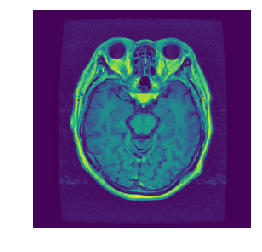

E:/GPImage/HandleImage/EnhanceImage/16.png
加载图像信息已完成


F:\anaconda\envs\GP\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


选中的模型为EYE-model
开始测试**********************
识别图像肿瘤类别程序开始运行
EYE-model
CNN-model
E:/GPImage/HandleImage/EnhanceImage/16.png
EYE-model
**********************
INFO:tensorflow:Restoring parameters from E:\GPImage\HandleImage\HandleEnhanceImage\model\CNN\eye\iris_model.ckpt-500
输入数据获取完毕
-----------------------
运算开始
-----------------------
运算结束，输出预测
[3]
预测为 pituitary tumor


In [ ]:
# 程序入口
def main():
    app = QtWidgets.QApplication(sys.argv)
    gui = MainUi()
    gui.show()
    sys.exit(app.exec_())
    
if __name__ == '__main__':
    main()